In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/blood-cells/dataset-master/dataset-master/labels.csv
/kaggle/input/blood-cells/dataset-master/dataset-master/Annotations/BloodImage_00236.xml
/kaggle/input/blood-cells/dataset-master/dataset-master/Annotations/BloodImage_00043.xml
/kaggle/input/blood-cells/dataset-master/dataset-master/Annotations/BloodImage_00281.xml
/kaggle/input/blood-cells/dataset-master/dataset-master/Annotations/BloodImage_00021.xml
/kaggle/input/blood-cells/dataset-master/dataset-master/Annotations/BloodImage_00377.xml
/kaggle/input/blood-cells/dataset-master/dataset-master/Annotations/BloodImage_00307.xml
/kaggle/input/blood-cells/dataset-master/dataset-master/Annotations/BloodImage_00199.xml
/kaggle/input/blood-cells/dataset-master/dataset-master/Annotations/BloodImage_00124.xml
/kaggle/input/blood-cells/dataset-master/dataset-master/Annotations/BloodImage_00132.xml
/kaggle/input/blood-cells/dataset-master/dataset-master/Annotations/BloodImage_00222.xml
/kaggle/input/blood-cells/dataset-master/da

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout,Dense,Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from flask import Flask,request,render_template,redirect,url_for
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import io
import base64



2025-06-28 03:16:35.469526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751080595.901378      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751080596.017839      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_dir='/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'

In [4]:
import os
from collections import Counter

train_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
print(class_counts)


{'MONOCYTE': 2478, 'NEUTROPHIL': 2499, 'LYMPHOCYTE': 2483, 'EOSINOPHIL': 2497}


In [5]:
class_labels=['NEUTROPHIL', 'MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL']

In [6]:

file_path=[]
labels=[]

In [7]:
for label in class_labels:
    class_dir=os.path.join(data_dir,label)
    for file in os.listdir(class_dir):
        if file.endswith('.jpeg') or file.endswith('.png'):
            file_path.append(os.path.join(class_dir,file))
            labels.append(label)


In [8]:
BloodCell_df=pd.DataFrame({
    'filepaths':file_path,
    'labels':labels
})

In [9]:
BloodCell_df.head()

,filepaths,labels
0,/kaggle/input/blood-cells/dataset2-master/data...,NEUTROPHIL
1,/kaggle/input/blood-cells/dataset2-master/data...,NEUTROPHIL
2,/kaggle/input/blood-cells/dataset2-master/data...,NEUTROPHIL
3,/kaggle/input/blood-cells/dataset2-master/data...,NEUTROPHIL
4,/kaggle/input/blood-cells/dataset2-master/data...,NEUTROPHIL


In [10]:
BloodCell_df.shape

(9957, 2)

In [11]:
train_images,test_images=train_test_split(BloodCell_df,test_size=0.3,random_state=42)
train_set,val_set=train_test_split(train_images,test_size=0.2,random_state=42)

In [12]:
print(train_images.shape)
print(test_images.shape)
print(train_set.shape)
print(val_set.shape)

(6969, 2)
(2988, 2)
(5575, 2)
(1394, 2)


In [13]:
val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)
image_gen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    brightness_range=[0.8, 1.2],
                                    shear_range=0.15,
                                    fill_mode='nearest'
)
train=image_gen.flow_from_dataframe(dataframe=train_set,
                                   target_size=(224,224),x_col='filepaths',y_col='labels',
                                   color_mode='rgb',
                                   class_mode='categorical',
                                   batch_size=8,
                                   shuffle=True)
test=val_test_datagen.flow_from_dataframe(dataframe=test_images,x_col='filepaths',y_col='labels',
                                   target_size=(224,224),
                                   color_mode='rgb',
                                   class_mode='categorical',
                                   batch_size=8,
                                   shuffle=False)
val=val_test_datagen.flow_from_dataframe(dataframe=val_set,x_col='filepaths',y_col='labels',
                                   target_size=(224,224),
                                   color_mode='rgb',
                                   class_mode='categorical',
                                   batch_size=8,
                                   shuffle=False)

Found 5575 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.
Found 1394 validated image filenames belonging to 4 classes.


In [14]:
#Need to work on this
from sklearn.utils.class_weight import compute_class_weight

# Get the class indices from generator
class_indices = train.class_indices  # {'eosinophil': 0, 'lymphocyte': 1, ...}
classes = list(class_indices.values())         # [0, 1, 2, 3]

# Get all labels from the generator
y_train = train.classes  # This gives you the class label (0, 1, 2, 3) for each image

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Convert to dict for use in model.fit()
class_weights_dict = dict(enumerate(class_weights))


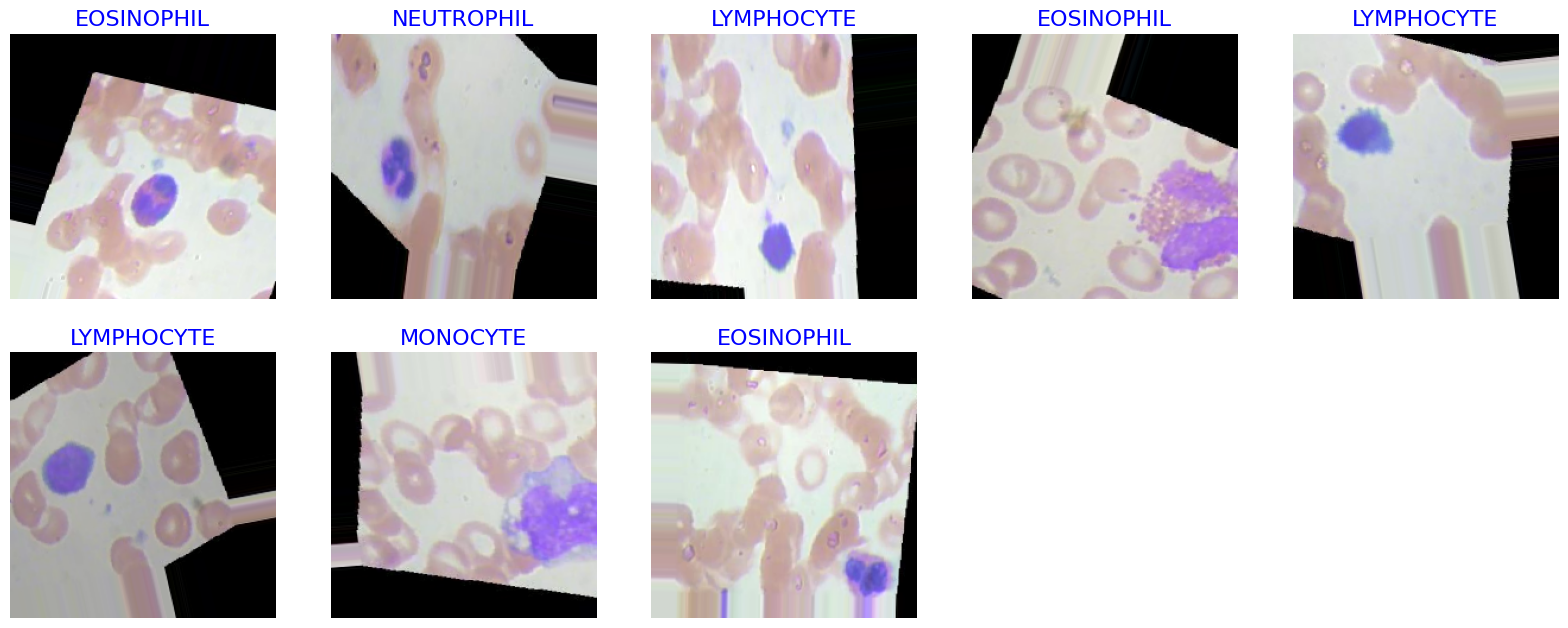

In [15]:
def show_knee_images(train):
    images,labels=next(train)
    train_dict=train.class_indices
    classes=list(train_dict.keys())
    plt.figure(figsize=(20,20))
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2
        plt.imshow(image)
        plt.axis('off')
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name,color='blue',fontsize=16)
    plt.show()
show_knee_images(train)



In [16]:
 base_model=MobileNetV2(weights="imagenet",include_top=False,input_shape=(224,224,3))
#base_model.trainable=False
 base_model.trainable = True

 for layer in base_model.layers[:100]:  # Freeze all but last 10 layers
    layer.trainable = False

I0000 00:00:1751080631.620587      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751080631.621252      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model=Sequential([base_model,
                GlobalAveragePooling2D(),
                # Flatten(),
                Dropout(0.5),
                Dense(1024,activation='relu'),
                Dropout(0.5),
                Dense(4,activation='softmax')])

In [18]:
model.compile(
loss='categorical_crossentropy',
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
metrics=['accuracy'])

In [19]:
checkpoint=ModelCheckpoint('blood_cell.h5',save_best_only=True,monitor='val_loss')
early_stop=EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,573,828 (13.63 MB)

 Trainable params: 3,177,284 (12.12 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [21]:
history=model.fit(train,
                 validation_data=val,
                 epochs=5,
                 callbacks=[checkpoint,early_stop],
                 class_weight=class_weights_dict
                 )
                  

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1751080653.239163      98 service.cc:148] XLA service 0x7f9ae4115a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751080653.240970      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751080653.240993      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751080655.130850      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/697 ━━━━━━━━━━━━━━━━━━━━ 5:49:19 30s/step - accuracy: 0.2500 - loss: 2.2116

I0000 00:00:1751080665.071249      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


697/697 ━━━━━━━━━━━━━━━━━━━━ 197s 240ms/step - accuracy: 0.5235 - loss: 1.1117 - val_accuracy: 0.6808 - val_loss: 1.1162
Epoch 2/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 90s 129ms/step - accuracy: 0.8617 - loss: 0.3655 - val_accuracy: 0.9319 - val_loss: 0.2177
Epoch 3/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 86s 124ms/step - accuracy: 0.9129 - loss: 0.2253 - val_accuracy: 0.9577 - val_loss: 0.1130
Epoch 4/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 86s 124ms/step - accuracy: 0.9375 - loss: 0.1696 - val_accuracy: 0.8924 - val_loss: 0.3352
Epoch 5/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 84s 120ms/step - accuracy: 0.9458 - loss: 0.1577 - val_accuracy: 0.9756 - val_loss: 0.0644


In [22]:
pred=model.predict(test)
pred=np.argmax(pred,axis=1)
labels=train.class_indices
labels=dict((v,k) for (k,v) in labels.items())#reverse {'0':eosinophil}
pred2=[labels[k] for k in pred]

374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step


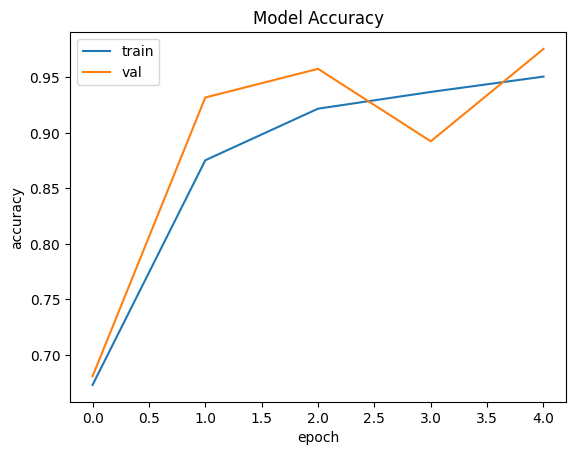

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

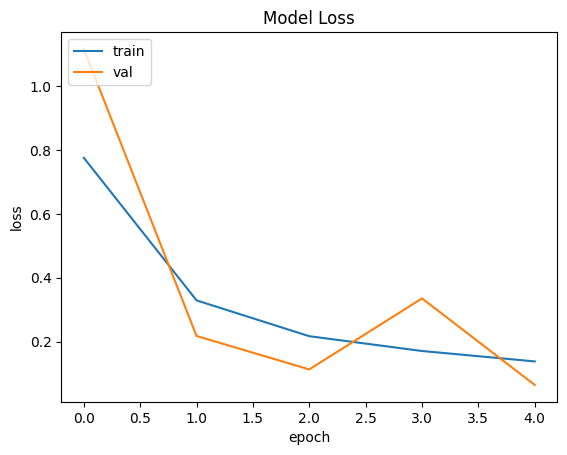

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

In [25]:
y_test=test_images.labels
print(classification_report(y_test,pred2))
print("Accuracy of the model","{:.1f}%".format(accuracy_score(y_test,pred2)*100))

              precision    recall  f1-score   support

  EOSINOPHIL       0.89      1.00      0.94       713
  LYMPHOCYTE       1.00      1.00      1.00       731
    MONOCYTE       0.99      1.00      0.99       762
  NEUTROPHIL       1.00      0.87      0.93       782

    accuracy                           0.97      2988
   macro avg       0.97      0.97      0.97      2988
weighted avg       0.97      0.97      0.96      2988

Accuracy of the model 96.5%


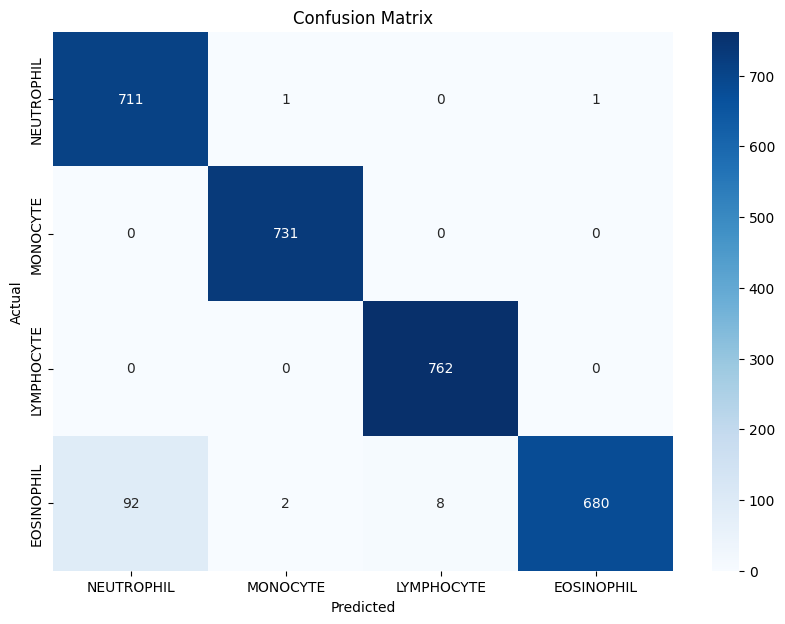

In [26]:
cm=confusion_matrix(y_test,pred2)
plt.figure(figsize=(10,7))
sns.heatmap(cm,cmap='Blues',vmin=0,annot=True,fmt='g')

plt.title("Confusion Matrix")
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




In [27]:
model.save('blood_cell.h5')